In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
import geoplot.crs as ccrs
import geoplot as gplt
%matplotlib inline

# Load Data

In [15]:
# Boroughs
boroughs = gpd.read_file("../data/nyc_boroughs/boroughs.geojson", driver='GeoJSON')
boroughs['Population'] = [378, 1951, 2300, 1487, 1203]
boroughs['Population Density'] = boroughs['Population'] / boroughs['Shape_Area']
boroughs = boroughs.set_index('BoroName')
boroughs.index = [b.upper() for b in boroughs.index]

# Collisions
cdata = pd.read_csv("../data/nyc_collisions/NYPD_Motor_Vehicle_Collisions.csv", index_col=0)
def pointify(srs):
    lat, long = srs['LATITUDE'], srs['LONGITUDE']
    if pd.isnull(lat) or pd.isnull(long):
        return Point(0, 0)
    else:
        return Point(long, lat)
collisions = gpd.GeoDataFrame(cdata.head(10000), geometry=cdata.head(10000).apply(pointify, axis='columns'))
collisions = collisions[collisions.geometry.map(lambda srs: not (srs.x == 0))]
del cdata

# Citibike (Network)
citibike = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/citibike-sankey/master/data/linesegments.csv", index_col=0)
def geometries(srs):
    start = Point(srs['Start Y'], srs['Start X'])
    end = Point(srs['End Y'], srs['End X'])
    return pd.Series({'From': start, 'To': end})
to_and_from = citibike.sample(1000).apply(geometries, axis='columns')

# Cities
cities = gpd.read_file("../data/cities/citiesx010g.shp")
cities = cities[cities['STATE'].map(lambda s: s not in ['PR', 'AK', 'HI', 'VI'])]

# Census Tracts
census_tracts = gpd.read_file("../data/nyc_census_tracts/census_tracts_2010.geojson", driver='GeoJSON')
from random import randint
census_tracts['mock_data'] = [randint(10, 1000) for _ in range(len(census_tracts))]

# WIP

-73.98233378
40.73173798


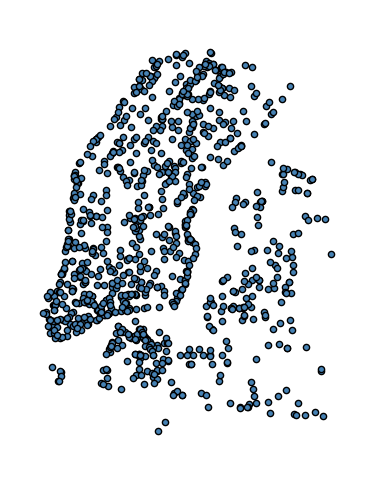

In [28]:
gplt.pointplot(gpd.GeoDataFrame(geometry=to_and_from['To']), projection=ccrs.PlateCarree())

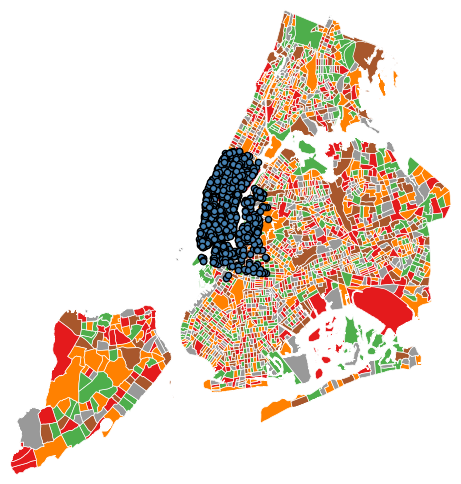

In [33]:
ax = gplt.choropleth(census_tracts, hue='mock_data', projection=ccrs.AlbersEqualArea(), edgecolor='white',
                     linewidth=0.5)
gplt.pointplot(gpd.GeoDataFrame(geometry=to_and_from['To']), projection=ccrs.PlateCarree(), 
               ax=ax, zorder=10)

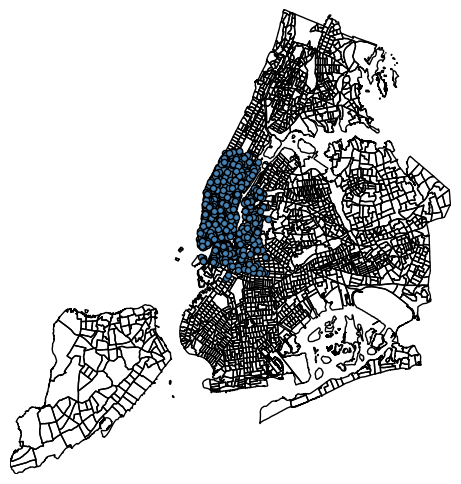

In [34]:
ax = gplt.polyplot(census_tracts, projection=ccrs.AlbersEqualArea())
gplt.pointplot(gpd.GeoDataFrame(geometry=to_and_from['To']), projection=ccrs.PlateCarree(), 
               ax=ax, zorder=10)

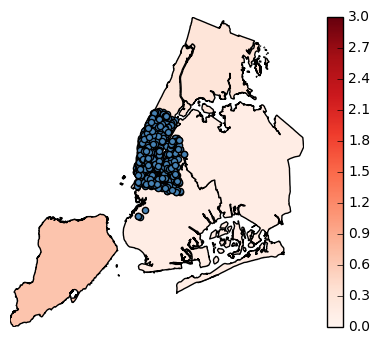

In [38]:
ax = gplt.aggplot(collisions.head(100), projection=ccrs.AlbersEqualArea(), hue='NUMBER OF PERSONS INJURED', cmap='Reds',
             geometry=boroughs, by='BOROUGH')
gplt.pointplot(gpd.GeoDataFrame(geometry=to_and_from['To']), projection=ccrs.PlateCarree(), 
               ax=ax, zorder=10)

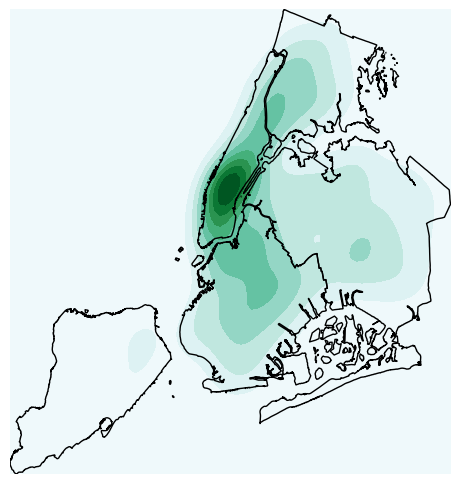

In [48]:
ax = gplt.kdeplot(collisions, projection=ccrs.AlbersEqualArea(), shade=True)
gplt.polyplot(boroughs, projection=ccrs.AlbersEqualArea(), ax=ax)

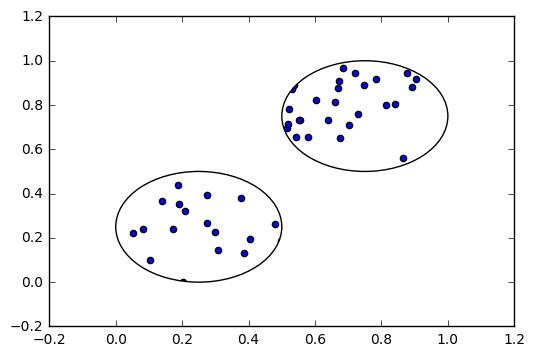

In [61]:
import matplotlib.patches as patches

np.random.seed(101)
x = np.random.random(100)
y = np.random.random(100)

fig = plt.figure()
ax = fig.add_subplot(111)
imForEngland = ax.scatter(x,y)
imForWales = ax.scatter(x,y)
england = patches.Circle((.75,.75),radius=.25,fc='none')
wales = patches.Circle((.25,.25),radius=.25,fc='none')
ax.add_patch(england)
ax.add_patch(wales)
imForEngland.set_clip_path(england)
imForWales.set_clip_path(wales)

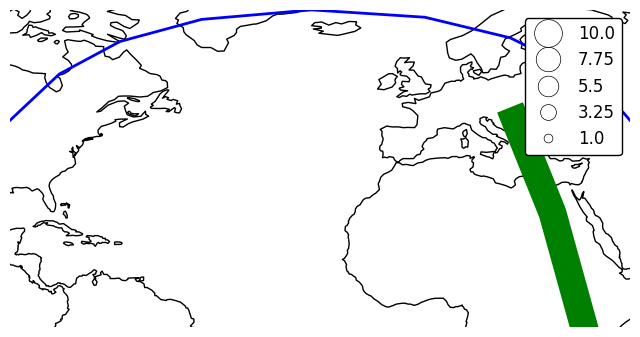

In [12]:
ax = gplt.sankey(start=gpd.GeoSeries([Point(-90, 45), Point(20, 45)]),
            end=gpd.GeoSeries([Point(45, 45), Point(35, 0)]),
            projection=ccrs.PlateCarree(),
            scale=[1, 10],
            limits=(2, 20),
            legend=True)
ax.coastlines()